---
title: GSB - S544 Lab 7
author: Karissa Mohr
format:
  html:
    embed-resources: true
echo: true
theme: lux
---

# Lab 7: Heart Attack


## The Data
In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain (“angina”) during exercise. The information collected includes:

* age : Age of the patient

* sex : Sex of the patient

* cp : Chest Pain type
  *  Value 0: asymptomatic
  * Value 1: typical angina
  * Value 2: atypical angina
  * Value 3: non-anginal pain

* trtbps : resting blood pressure (in mm Hg)

* chol : cholesterol in mg/dl fetched via BMI sensor

* restecg : resting electrocardiographic results
  * Value 0: normal
  * Value 1: having ST-T wave abnormality (T wave inversions and/or ST
  elevation or depression of > 0.05 mV)
  * Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria

* thalach : maximum heart rate achieved during exercise

* output : the doctor’s diagnosis of whether the patient is at risk for a heart attack
  * 0 = not at risk of heart attack
  * 1 = at risk of heart attack

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report, cohen_kappa_score


In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


In [4]:
# clean/check data
ha.info()
ha.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


,0
age,0
sex,0
cp,0
trtbps,0
chol,0
restecg,0
thalach,0
output,0


## Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

* Find the best model based on ROC AUC for predicting the target variable.

* Report the (cross-validated!) ROC AUC metric.

* Fit the final model.

* Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

* (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

* Q1: KNN
* Q2: Logistic Regression
* Q3: Decision Tree
* Q4: Interpretation
  * Which predictors were most important to predicting heart attack risk?
* Q5: ROC Curve
  * Plot the ROC Curve for your three models above.

In [6]:
# target & predictor variable
X = ha.drop(columns=['output'])
y = ha['output']

In [19]:
# KNN model
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [8]:
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 21)}

grid_knn = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10
)

grid_knn.fit(X, y)
grid_knn.best_params_, grid_knn.best_score_

({'kneighborsclassifier__n_neighbors': 19}, np.float64(0.839090354090354))

In [9]:
knn_best = grid_knn.best_estimator_
knn_best.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=19))])

In [10]:
y_pred_knn = knn_best.predict(X)
y_proba_knn = knn_best.predict_proba(X)[:, 1]

confusion_matrix(y, y_pred_knn)
roc_auc_score(y, y_proba_knn)

np.float64(0.8609912630784164)

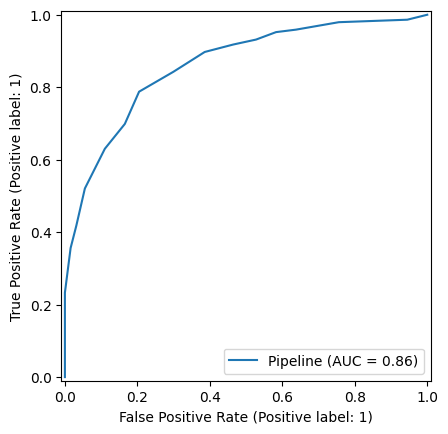

In [11]:
RocCurveDisplay.from_estimator(knn_best, X, y)

In [12]:
# logistic model
from sklearn.linear_model import LogisticRegression

log_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

In [13]:
param_grid = {'logisticregression__C': np.logspace(-3, 3, 10)}

grid_log = GridSearchCV(
    log_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10
)

grid_log.fit(X, y)
grid_log.best_params_, grid_log.best_score_

({'logisticregression__C': np.float64(0.001)}, np.float64(0.8541208791208792))

In [14]:
log_best = grid_log.best_estimator_
log_best.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=np.float64(0.001), max_iter=1000))])

In [15]:
y_pred_log = log_best.predict(X)
y_proba_log = log_best.predict_proba(X)[:, 1]

confusion_matrix(y, y_pred_log)
roc_auc_score(y, y_proba_log)

np.float64(0.8603171178945098)

In [16]:
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': log_best.named_steps['logisticregression'].coef_[0]
}).sort_values('Coefficient', ascending=False)
coef_df

,Variable,Coefficient
2,cp,0.052112
6,thalach,0.050823
5,restecg,0.017468
4,chol,-0.009483
3,trtbps,-0.016760
0,age,-0.028658
1,sex,-0.038708


It looks like higher chest pain levels, maximum heart rate, and resting ECG values are linked to a higher chance of heart attack, while lower cholesterol, blood pressure, age, and being male appear to be linked to a lower chance?

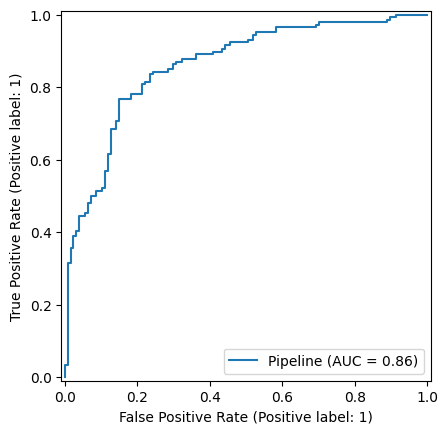

In [17]:
RocCurveDisplay.from_estimator(log_best, X, y)

The Logistic Regression ROC curve looks a little less smooth than the KNN curve. That’s because KNN gives more discrete probability values based on the nearest neighbors, while Logistic Regression gives continuous probabilities. The ROC AUC scores are almost the same though, KNN = 0.8610 and Logistic = 0.8603, so they perform basically equally well at separating patients at risk from those not at risk.

In [20]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

tree_pipe = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=1)
)

In [21]:
param_grid = {'decisiontreeclassifier__max_depth': range(1, 15)}

grid_tree = GridSearchCV(
    tree_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10
)

grid_tree.fit(X, y)
grid_tree.best_params_, grid_tree.best_score_

({'decisiontreeclassifier__max_depth': 3}, np.float64(0.800369352869353))

In [22]:
tree_best = grid_tree.best_estimator_
tree_best.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3, random_state=1))])

In [23]:
y_pred_tree = tree_best.predict(X)
y_proba_tree = tree_best.predict_proba(X)[:, 1]

confusion_matrix(y, y_pred_tree)
roc_auc_score(y, y_proba_tree)

np.float64(0.8771168158774674)

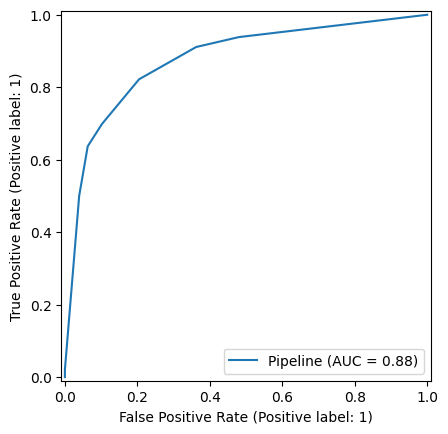

In [24]:
RocCurveDisplay.from_estimator(tree_best, X, y)

In [26]:
importance = tree_best.named_steps['decisiontreeclassifier'].feature_importances_

pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

,Feature,Importance
2,cp,0.564630
0,age,0.151122
6,thalach,0.112866
1,sex,0.099147
3,trtbps,0.072235
4,chol,0.000000
5,restecg,0.000000


It looks like the most important factors to consider when looking at risk of heart attack is chest pain type, age and resting blood pressure.

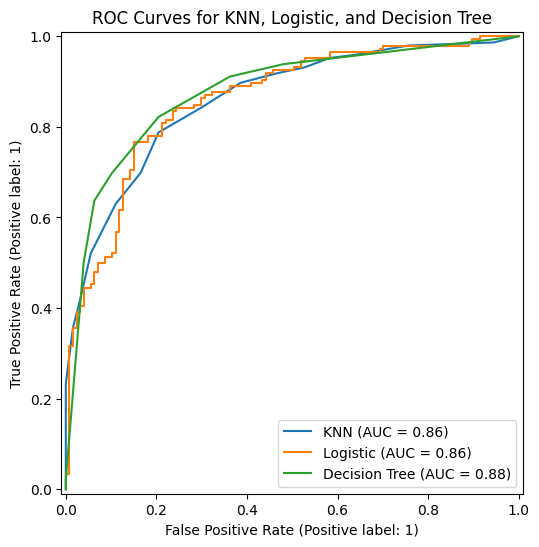

In [27]:
# all roc curves

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

RocCurveDisplay.from_estimator(knn_best, X, y, name='KNN', ax=plt.gca())
RocCurveDisplay.from_estimator(log_best, X, y, name='Logistic', ax=plt.gca())
RocCurveDisplay.from_estimator(tree_best, X, y, name='Decision Tree', ax=plt.gca())

plt.title('ROC Curves for KNN, Logistic, and Decision Tree')
plt.show()

## Part Two: Metrics
Consider the following metrics:

* True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

* Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

* True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?


Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np

In [29]:
is_positive = (y == 1)
is_negative = (y == 0)

In [31]:
# KNN
# precision
knn_prec_cv = cross_val_score(knn_best, X, is_positive, cv=10, scoring="precision")
# sensitivity
knn_rec_cv  = cross_val_score(knn_best, X, is_positive, cv=10, scoring="recall")
# specificity
knn_spec_cv = cross_val_score(knn_best, X, is_negative, cv=10, scoring="recall")

print("Precision mean:", knn_prec_cv.mean(), "std:", knn_prec_cv.std())
print("Sensitivity mean:", knn_rec_cv.mean(), "std:", knn_rec_cv.std())
print("Specificity mean:", knn_spec_cv.mean(), "std:", knn_spec_cv.std())


Precision mean: 0.7485352474323063 std: 0.1021007505796849
Sensitivity mean: 0.8214285714285714 std: 0.1009085709072311
Specificity mean: 0.6782051282051282 std: 0.13681956136985138


In [32]:
# Logistic
# precision
log_prec_cv = cross_val_score(log_best, X, is_positive, cv=10, scoring="precision")
# sensitivity
log_rec_cv  = cross_val_score(log_best, X, is_positive, cv=10, scoring="recall")
# specificity
log_spec_cv = cross_val_score(log_best, X, is_negative, cv=10, scoring="recall")

print("Precision mean:", log_prec_cv.mean(), "std:", log_prec_cv.std())
print("Sensitivity mean:", log_rec_cv.mean(), "std:", log_rec_cv.std())
print("Specificity mean:", log_spec_cv.mean(), "std:", log_spec_cv.std())

Precision mean: 0.5783068702633919 std: 0.0432147209300895
Sensitivity mean: 0.9790476190476192 std: 0.0452355889030016
Specificity mean: 0.17564102564102563 std: 0.10352911401652522


In [33]:
# Decision Tree
# precision
tree_prec_cv = cross_val_score(tree_best, X, is_positive, cv=10, scoring="precision")
# sensitivity
tree_rec_cv  = cross_val_score(tree_best, X, is_positive, cv=10, scoring="recall")
# specificity
tree_spec_cv = cross_val_score(tree_best, X, is_negative, cv=10, scoring="recall")

print("Precision mean:", tree_prec_cv.mean(), "std:", tree_prec_cv.std())
print("Sensitivity mean:", tree_rec_cv.mean(), "std:", tree_rec_cv.std())
print("Specificity mean:", tree_spec_cv.mean(), "std:", tree_spec_cv.std())

Precision mean: 0.7999216224951519 std: 0.08392304173364923
Sensitivity mean: 0.7247619047619047 std: 0.13766435240432615
Specificity mean: 0.7955128205128206 std: 0.0793138101050049


## Part Three: Discussion
Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

* Which metric(s) you would use for model selection and why.

* Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

* What score you should expect for your chosen metric(s) using your chosen model to predict future observations.



### Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

If the hospital is most worried about getting sued for missing patients who actually are at risk, the key metric is sensitivity. This measures how many true positive cases the model correctly identifies. Logistic Regression had the highest sensitivity at 0.979, meaning it catches nearly everyone who is at risk, so it’s the safest choice in that scenario.

### Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

If the hospital is overfull and needs to make sure it only monitors patients who really need it, the most important metrics are precision and specificity. Precision measures how many of the patients flagged as high risk actually are high risk, and specificity measures how well the model avoids false positives. The Decision Tree had the best precision (0.80) and specificity (0.80), so it would be the best model for this.

### Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

If the hospital wants to study what biological factors lead to heart attacks, Logistic Regression is best because its coefficients show how each variable relates to heart attack risk, so doctors can see which predictors matter most.

### Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

If the hospital wants to compare new doctors diagnoses to the model’s predictions, the best overall metric is ROC AUC, since it shows how well the model separates high-risk and low-risk patients overall. The Decision Tree had the highest ROC AUC at 0.88, meaning it distinguishes the two groups the best, so it would be the best model for this case.

## Part Four: Validation
Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

In [36]:
ha_val = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [37]:
X_val = ha_val.drop(columns=['output'])
y_val = ha_val['output']

In [38]:
# KNN
y_pred_knn_val = knn_best.predict(X_val)
y_proba_knn_val = knn_best.predict_proba(X_val)[:,1]

print("KNN Confusion Matrix:\n", confusion_matrix(y_val, y_pred_knn_val))
print("KNN ROC AUC:", roc_auc_score(y_val, y_proba_knn_val))
print("KNN Precision:", precision_score(y_val, y_pred_knn_val))
print("KNN Recall:", recall_score(y_val, y_pred_knn_val))

KNN Confusion Matrix:
 [[11  0]
 [ 6 13]]
KNN ROC AUC: 0.9425837320574163
KNN Precision: 1.0
KNN Recall: 0.6842105263157895


In [39]:
# Logistic
y_pred_log_val = log_best.predict(X_val)
y_proba_log_val = log_best.predict_proba(X_val)[:,1]

print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_val, y_pred_log_val))
print("Logistic Regression ROC AUC:", roc_auc_score(y_val, y_proba_log_val))
print("Logistic Regression Precision:", precision_score(y_val, y_pred_log_val))
print("Logistic Regression Recall:", recall_score(y_val, y_pred_log_val))

Logistic Regression Confusion Matrix:
 [[ 2  9]
 [ 0 19]]
Logistic Regression ROC AUC: 0.9521531100478469
Logistic Regression Precision: 0.6785714285714286
Logistic Regression Recall: 1.0


In [40]:
# Decision Tree
y_pred_tree_val = tree_best.predict(X_val)
y_proba_tree_val = tree_best.predict_proba(X_val)[:,1]

print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_val, y_pred_tree_val))
print("Decision Tree ROC AUC:", roc_auc_score(y_val, y_proba_tree_val))
print("Decision Tree Precision:", precision_score(y_val, y_pred_tree_val))
print("Decision Tree Recall:", recall_score(y_val, y_pred_tree_val))

Decision Tree Confusion Matrix:
 [[ 8  3]
 [ 7 12]]
Decision Tree ROC AUC: 0.7775119617224879
Decision Tree Precision: 0.8
Decision Tree Recall: 0.631578947368421


* KNN had an ROC AUC of 0.94, meaning it can correctly separate high and low risk patients about 94% of the time. Its precision of 1.0 means every patient it predicted as at risk actually was, but its recall of 0.68 shows it missed some true cases.
* Logistic Regression had the highest ROC AUC at 0.95 and perfect recall (1.0), meaning it caught all at-risk patients but also had more false alarms, with a precision of 0.68.
* The Decision Tree had the lowest ROC AUC (0.78) and lower recall (0.63), so it didn’t generalize as well.

Overall, these results confirm that cross-validation gave a good estimate of model performance, and Logistic Regression performs best at identifying all at-risk patients.

## Part Five: Cohen’s Kappa
Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [41]:
from sklearn.metrics import cohen_kappa_score

# KNN
kappa_knn = cohen_kappa_score(y_val, y_pred_knn_val)
# Logistic Regression
kappa_log = cohen_kappa_score(y_val, y_pred_log_val)
# Decision Tree
kappa_tree = cohen_kappa_score(y_val, y_pred_tree_val)

print("KNN Kappa:", kappa_knn)
print("Logistic Regression Kappa:", kappa_log)
print("Decision Tree Kappa:", kappa_tree)

KNN Kappa: 0.6137339055793991
Logistic Regression Kappa: 0.21965317919075156
Decision Tree Kappa: 0.33333333333333337


* KNN had the highest Kappa at 0.61, which means it agreed with the true results much more than random and performed the best overall on new data.
* Logistic Regression had a low Kappa of 0.22, meaning it didn’t agree with the actual outcomes much better than chance, probably because it predicted almost everyone as at risk.
* The Decision Tree was in between at 0.33, showing moderate agreement.

If we judge the models using Kappa, KNN would be the best choice since it was the most reliable overall and balanced both correct positives and negatives better than the others.